Date 2019=1, Predicted=100.531598, Expected=99.673705
Date 2019=2, Predicted=99.481626, Expected=99.480289
Date 2019=3, Predicted=99.288210, Expected=98.512288
Date 2019=4, Predicted=98.320209, Expected=98.227690
Date 2019=5, Predicted=98.035611, Expected=97.076405
Date 2019=6, Predicted=96.884326, Expected=96.569839
Date 2019=7, Predicted=96.377760, Expected=96.873778
Date 2019=8, Predicted=96.681699, Expected=95.860647
Date 2019=9, Predicted=95.668568, Expected=94.718572
Date 2019=10, Predicted=94.526493, Expected=94.884357
Date 2019=11, Predicted=94.692278, Expected=90.550918
Date 2019=12, Predicted=90.358839, Expected=89.800280
Date 2019=13, Predicted=89.608200, Expected=88.004274
Date 2019=14, Predicted=87.812195, Expected=90.233163
Date 2019=15, Predicted=90.041084, Expected=92.462052
Date 2019=16, Predicted=92.269973, Expected=93.327819
Date 2019=17, Predicted=93.135740, Expected=92.738360
Date 2019=18, Predicted=92.546281, Expected=93.521235
Date 2019=19, Predicted=93.329156, E

Date 2019=254, Predicted=67.234682, Expected=67.552860
Date 2019=255, Predicted=67.360781, Expected=66.859317
Date 2019=256, Predicted=66.667238, Expected=69.002995
Date 2019=257, Predicted=68.810916, Expected=68.072695
Date 2019=258, Predicted=67.880616, Expected=68.365424
Date 2019=259, Predicted=68.173345, Expected=67.552860
Date 2019=260, Predicted=67.360781, Expected=66.780827
Date 2019=261, Predicted=66.588748, Expected=67.733644
Date 2019=262, Predicted=67.541565, Expected=65.850528
Date 2019=263, Predicted=65.658449, Expected=65.106803
Date 2019=264, Predicted=64.914724, Expected=64.333484
Date 2019=265, Predicted=64.141405, Expected=64.437708
Date 2019=266, Predicted=64.245629, Expected=64.015020
Date 2019=267, Predicted=63.822941, Expected=63.027462
Date 2019=268, Predicted=62.835383, Expected=62.662033
Date 2019=269, Predicted=62.469954, Expected=63.219183
Date 2019=270, Predicted=63.027104, Expected=62.359654
Date 2019=271, Predicted=62.167574, Expected=63.041616
Date 2019=

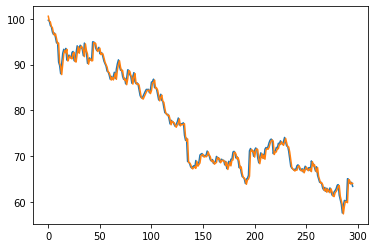

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from keras.layers import LSTM
from math import sqrt
import numpy
from matplotlib import pyplot
import numpy as np

def parser(x):
    return datetime.strptime(x, '%d-%m-%y')

# Observation from t-1 as input and t as output
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# fit LSTM to data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# scale train and test data [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers


def main():
    series = read_csv('EOD-AAPL.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    # transform data to be stationary

outliers=[]
series=DataFrame(series)
outlier_datapoints = detect_outlier(series.Adj_Open)

out=set(outlier_datapoints)
out=list(out)
out=np.array(out)
n=len(out)
series=series.reset_index()
series=series.set_index('Adj_Open')
for i in range(n):
    a=out[i]
    series=series.drop(a,axis=0)
series=series.reset_index()
series=series.set_index('Date')

raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-296], supervised_values[-296:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# Validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Date 2019=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    

mse = sqrt(mean_squared_error(raw_values[-296:], predictions))
print('Test RMSE: %.3f' % mse)
pyplot.plot(raw_values[-296:])
pyplot.plot(predictions)
pyplot.show()

In [7]:
from sklearn.externals import joblib
joblib.dump(lr, 'model.pkl')
lr = joblib.load('model.pkl')

c:\users\kaushik\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
